Pair1.xlsx


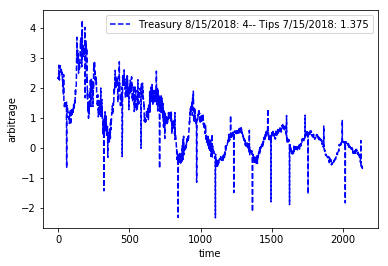

Pair2.xlsx


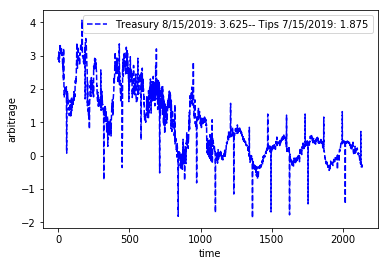

Pair3.xlsx


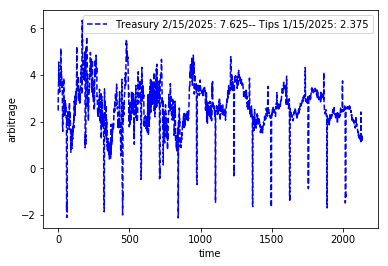

Pair4.xlsx


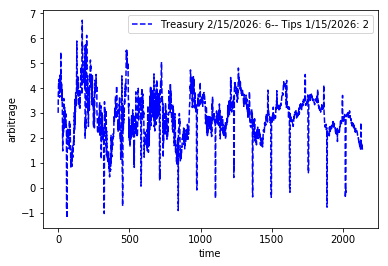

Pair5.xlsx


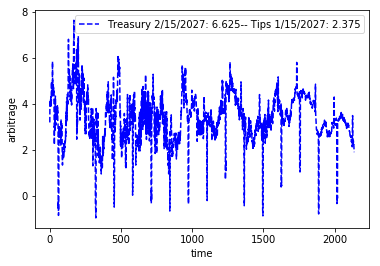

Pair6.xlsx


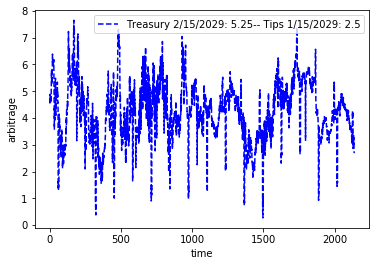

  Maturity Treasury Treasury Maturity Tips   Tips      Mean  \
0         8/15/2018        4     7/15/2018  1.375  0.729315   
1         8/15/2019    3.625     7/15/2019  1.875  0.927626   
2         2/15/2025    7.625     1/15/2025  2.375  2.595016   
3         2/15/2026        6     1/15/2026  2.000  2.858856   
4         2/15/2027    6.625     1/15/2027  2.375  3.370344   
5         2/15/2029     5.25     1/15/2029  2.500  4.234988   

   Standard Deviation       Max       Min  
0            0.936996  4.254365 -2.346860  
1            1.011866  4.062697 -1.863080  
2            1.046208  6.343331 -2.133014  
3            0.967234  6.722903 -1.200053  
4            1.072287  7.633353 -0.963910  
5            1.123089  7.650134  0.266664  


In [4]:
## Extended Time Period from 2

import math
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
from pandas import ExcelWriter
from pandas import ExcelFile


def disFactInpolDate(discFacs, maturityYears, interpolatedPeriods ):
    #print(" Enter: disFactInpolDate")
    discFactors =  list(discFacs)   
    periods = [x * 2 for x in maturityYears] 
    intPolStrips = interp1d(periods, discFactors, kind='cubic')
    discFact = intPolStrips(interpolatedPeriods)
    #print(" Exit: disFactInpolDate")
    return discFact


def swapInterPolate(valueData, maturityYears, interpolatedPeriods , tipsCouponRate):
    #print(" Enter: swapInterPolate")
    swapPeriods = [x * 2 for x in maturityYears]
    inflationSwap = []
    swapRates =  list(valueData)
    for i in range(len(swapPeriods)):
        inflationSwap.append(tipsCouponRate/2 * math.pow((1+swapRates[i]/200), swapPeriods[i]))
    intPolSwap = interp1d(swapPeriods, inflationSwap, kind='cubic')
    intPolSwapPrice = intPolSwap(interpolatedPeriods)
    #print(" Exit: swapInterPolate")
    return intPolSwapPrice

def funcReadSwapData():
    #print(" Enter: funcReadSwapData")
    df = pd.read_excel('timeframeExtended/swap.xlsx', sheet_name='swaps')
    matYrs = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            drDict[t] = df.iloc[i,0:16]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:16]
    #print(" Exit: funcReadSwapData")
    return drDict, matYrs
    
def funcReadStripsData():
    #print(" Enter: funcReadStripsData")
    df = pd.read_excel('timeframeExtended/disFactors.xlsx', sheet_name='factors')
    maturityYears = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            st = datetime.strptime(t, "%m/%d/%Y")
            string = '{:%m/%d/%Y}'.format(st)
            drDict[string] = df.iloc[i,0:15]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:15]
    #print(" Exit: funcReadStripsData")
    return drDict, maturityYears

def matchTreasuryTipsDate(name):
    #print(" Enter: matchTreasuryTipsDate")
    excelName = name+ ".xlsx"
    print(excelName)
    df = pd.read_excel("timeframeExtended/"+ excelName, sheet_name='Sheet1')
    df.head()

    treasuryCouponRate = df.columns.tolist()[1]
    tipsCouponRate = df.columns.tolist()[3]

    trsMatur = df.iloc[0,1]
    tpsMatur = df.iloc[0,3]
    pairDictionTemp = {}
    pairDictionConcise = {}

    for i in range(2, len(df.iloc[:,1])):
        if(math.isnan(df.iloc[i,1])):
            print("Parsing treasury data")
        else:
            t = df.iloc[i,0]
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,0])
            pairDictionTemp[string] = df.iloc[i,1]
        
    for i in range(2, len(df.iloc[:,3])):
   
        if(math.isnan(df.iloc[i,3]) ):
            print("Parsing tips data ")
        else:
            t = df.iloc[i,2]
            
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,2])
                
            if string in pairDictionTemp:
                pairDictionConcise[string] = [pairDictionTemp[string], df.iloc[i,3]]
            else:
                print("tips treasury date mismatch")
    #print(" Exit: matchTreasuryTipsDate")
    return treasuryCouponRate, tipsCouponRate, trsMatur, tpsMatur, pairDictionConcise

def getIntPolPeriod(MaturityDate, StartDate):
    #print(" Enter: getIntPolPeriod")
    if(type(MaturityDate)== str):
        mat = datetime.strptime(MaturityDate, "%m/%d/%Y").timestamp()   
    else:
        mat = MaturityDate.timestamp()
    if(type(StartDate)== str):
        start = datetime.strptime(StartDate, "%m/%d/%Y").timestamp()   
    else:
        start = StartDate.timestamp()    
    counter = 0
    while(mat > start):
        counter = counter + 1
        mat =  mat - 15768000
    days =  int((mat+ 15768000- start)/86400)
    interpolatedPeriods = []
    for i in range(counter):
        interpolatedPeriods.append(days/180 + i)
    #print(" Exit: getIntPolPeriod")
    return interpolatedPeriods

def getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate):
    #print(" Enter: getSynBondPrice")
    synBondPrice = 0
    for i in range(len(newSwapRates)):
        if i == (len(newSwapRates) -1 ):
            temp = (100+tipsCouponRate/2)* (newSwapRates[i]/(tipsCouponRate/2))
            val = (100 + trsCouponRate/2) -  temp
            synBondPrice = synBondPrice + val*newDiscFactors[i]
        else:
            val = trsCouponRate/2 -  newSwapRates[i]
            synBondPrice = synBondPrice + val*newDiscFactors[i]
    #print(" Exit: getSynBondPrice")
    return synBondPrice


def funMatMismatchYTM(price, matArr, coup, freq, guess):
    ytm_func = lambda y: sum([coup/((1+y/freq)**t) for t in matArr]) + 100 / ((1+y/freq)** matArr[-1]) - price    
    return optimize.newton(ytm_func, guess)

def calBondPriceYTM(coup, freq, matArr, ytm ):
    price = sum([coup/((1+ytm/freq)**t) for t in matArr]) + 100 / ((1+ytm/freq)** matArr[-1])
    return price

def main():
    
    stripsData, matStrips = funcReadStripsData()
    swapData, matSwaps = funcReadSwapData()
    #pairName = ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5', 'Pair6', 'Pair7', 'Pair8', 'Pair9', 'Pair10', 'Pair11' , 'Pair12']
    pairName = ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5', 'Pair6']
    finalFrame =  pd.DataFrame(columns=['Maturity Treasury', 'Treasury', 'Maturity Tips', 'Tips', 'Mean', 'Standard Deviation', 'Max', 'Min'])
           
    for k in range(len(pairName)):
        writer = ExcelWriter("result6Pairs2009-2017/"+pairName[k]+ "result.xlsx")
        trsCouponRate, tipsCouponRate, trsMatur, tpsMatur, matchDateTpsTrs = matchTreasuryTipsDate(pairName[k])
        printString = "Treasury "+ str(trsMatur)+": "+ str(trsCouponRate)+"-- Tips "+ str(tpsMatur)+": "+ str(tipsCouponRate)
        
        tinyArbitFrame = pd.DataFrame(columns = ['Date','Arbitrage'])
        arbitrageArray = []
        timeArr = []
        i = 1
       
        for key in matchDateTpsTrs:
            intPolTrs = getIntPolPeriod(trsMatur, key)
            intPolTps = getIntPolPeriod(tpsMatur, key)


            if key in stripsData and key in swapData:
                newDiscFactors = disFactInpolDate(stripsData[key], matStrips, intPolTps)
                newSwapRates = swapInterPolate(swapData[key], matSwaps, intPolTps, tipsCouponRate)

                synBondPrice = getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate) + matchDateTpsTrs[key][1]
                ytm = funMatMismatchYTM(synBondPrice, intPolTps, trsCouponRate/2, 2, 0)
                if(ytm < 0.10):
                    synBondPriceYtm = calBondPriceYTM(trsCouponRate/2, 2, intPolTrs, ytm )
                    tinyArbitrage = matchDateTpsTrs[key][0] -synBondPriceYtm
                    #print(matchDateTpsTrs[key][0])
                    #print(key+" " + str(synBondPrice) + " "+ str(ytm) + " "+ str(synBondPriceYtm)+"arbit:" +str(tinyArbitrage ))
                    
                    arbitrageArray.append(tinyArbitrage)
                    tinyArbitFrame.loc[i] = [key, tinyArbitrage]
                    timeArr.append(i)
                    i = i+1    
        
        tinyArbitFrame.to_excel(writer,pairName[k],index=False)
        writer.save()

        plt.plot(timeArr, arbitrageArray, 'b--', label = printString)
        plt.ylabel('arbitrage')
        plt.xlabel('time')
        plt.legend()
        plt.show() 
            
        finalFrame.loc[k] = [trsMatur, trsCouponRate, tpsMatur,tipsCouponRate, np.mean(arbitrageArray), np.std(arbitrageArray), max(arbitrageArray), min(arbitrageArray)]

#     print(printString)       
#     print("Max:" + str(max(arbitrageArray)))  
#     print("Min:" + str(min(arbitrageArray)))
#     print("Mean:" + str(np.mean(arbitrageArray)))  
#     print("Standard Deviation:" + str(np.std(arbitrageArray)))

    print(finalFrame)
    finalFrame.to_html('result6Pairs2009-2017/finalTable.html')
     
        
if __name__=='__main__':
    main()

Pair1.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

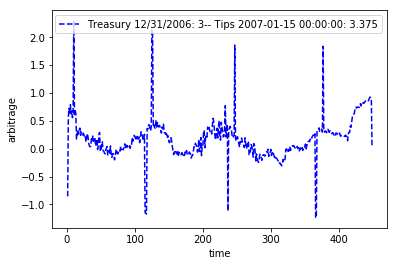

Pair2.xlsx
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 


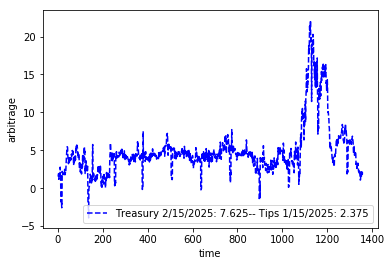

Pair3.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

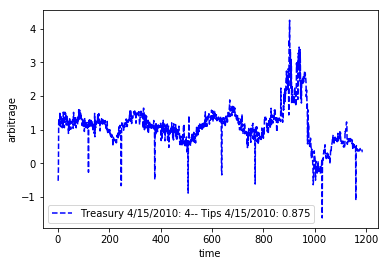

Pair4.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

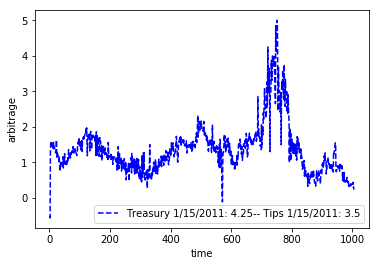

Pair5.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

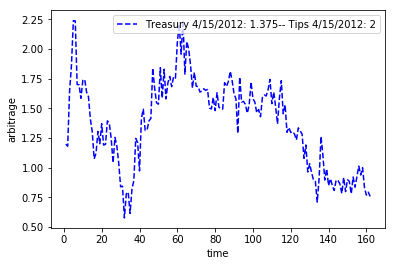

Pair6.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing tr

tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date m

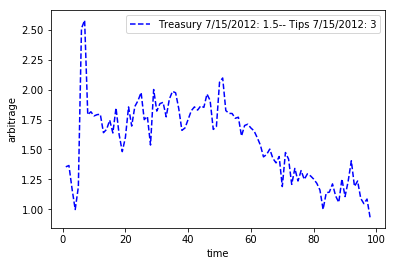

Pair7.xlsx
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 


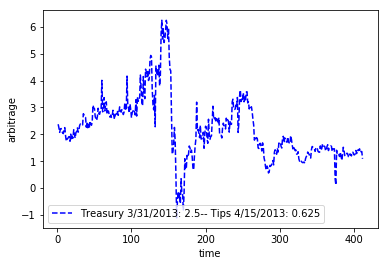

Pair8.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing tr

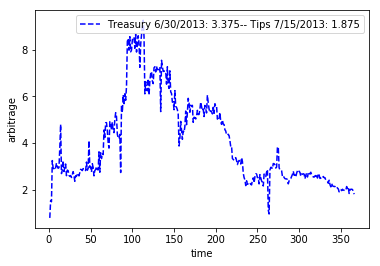

Pair9.xlsx
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data

Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing treasury data
Parsing tr

tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date mismatch
tips treasury date m

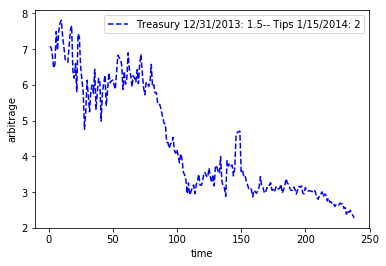

Pair10.xlsx
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 


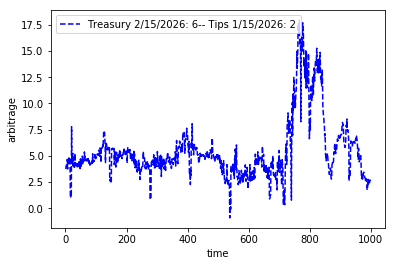

Pair11.xlsx
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 


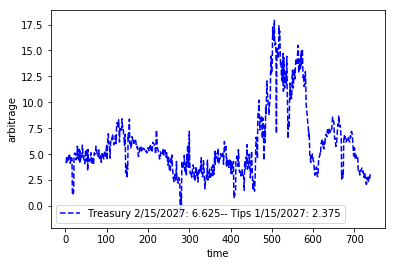

Pair12.xlsx
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 
Parsing tips data 


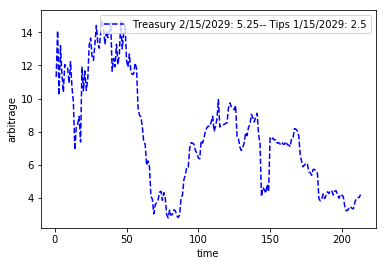

   Maturity Treasury Treasury        Maturity Tips   Tips      Mean  \
0         12/31/2006        3  2007-01-15 00:00:00  3.375  0.173436   
1          2/15/2025    7.625            1/15/2025  2.375  4.831810   
2          4/15/2010        4            4/15/2010  0.875  1.093788   
3          1/15/2011     4.25            1/15/2011  3.500  1.359952   
4          4/15/2012    1.375            4/15/2012  2.000  1.371418   
5          7/15/2012      1.5            7/15/2012  3.000  1.576813   
6          3/31/2013      2.5            4/15/2013  0.625  2.193086   
7          6/30/2013    3.375            7/15/2013  1.875  3.988590   
8         12/31/2013      1.5            1/15/2014  2.000  4.395854   
9          2/15/2026        6            1/15/2026  2.000  5.423325   
10         2/15/2027    6.625            1/15/2027  2.375  5.918375   
11         2/15/2029     5.25            1/15/2029  2.500  7.730278   

    Standard Deviation        Max       Min  
0             0.361457   2.304

In [3]:
## Time Period Mentioned in the Paper 2004-2009 for 12 pairs

import math
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime
from pandas import ExcelWriter
from pandas import ExcelFile


def disFactInpolDate(discFacs, maturityYears, interpolatedPeriods ):
    #print(" Enter: disFactInpolDate")
    discFactors =  list(discFacs)   
    periods = [x * 2 for x in maturityYears] 
    intPolStrips = interp1d(periods, discFactors, kind='cubic')
    discFact = intPolStrips(interpolatedPeriods)
    #print(" Exit: disFactInpolDate")
    return discFact


def swapInterPolate(valueData, maturityYears, interpolatedPeriods , tipsCouponRate):
    #print(" Enter: swapInterPolate")
    swapPeriods = [x * 2 for x in maturityYears]
    inflationSwap = []
    swapRates =  list(valueData)
    for i in range(len(swapPeriods)):
        inflationSwap.append(tipsCouponRate/2 * math.pow((1+swapRates[i]/200), swapPeriods[i]))
    intPolSwap = interp1d(swapPeriods, inflationSwap, kind='cubic')
    intPolSwapPrice = intPolSwap(interpolatedPeriods)
    #print(" Exit: swapInterPolate")
    return intPolSwapPrice

def funcReadSwapData():
    #print(" Enter: funcReadSwapData")
    df = pd.read_excel('timeframePaper/swap.xlsx', sheet_name='swaps')
    matYrs = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            drDict[t] = df.iloc[i,0:16]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:16]
    #print(" Exit: funcReadSwapData")
    return drDict, matYrs
    
def funcReadStripsData():
    #print(" Enter: funcReadStripsData")
    df = pd.read_excel('timeframePaper/disFactors.xlsx', sheet_name='factors')
    maturityYears = df.columns.tolist()
    listDates =list(df.index)  
    n =  len(listDates)
    drDict = {}
    for i in range(n):
        t = listDates[i]
        if(type(t)== str):
            st = datetime.strptime(t, "%m/%d/%Y")
            string = '{:%m/%d/%Y}'.format(st)
            drDict[string] = df.iloc[i,0:15]
        else:
            string = '{:%m/%d/%Y}'.format(t)
            drDict[string] = df.iloc[i,0:15]
    #print(" Exit: funcReadStripsData")
    return drDict, maturityYears

def matchTreasuryTipsDate(name):
    #print(" Enter: matchTreasuryTipsDate")
    excelName = name+ ".xlsx"
    print(excelName)
    df = pd.read_excel("timeframePaper/"+excelName, sheet_name='Sheet1')
    df.head()

    treasuryCouponRate = df.columns.tolist()[1]
    tipsCouponRate = df.columns.tolist()[3]

    trsMatur = df.iloc[0,1]
    tpsMatur = df.iloc[0,3]
    pairDictionTemp = {}
    pairDictionConcise = {}

    for i in range(2, len(df.iloc[:,1])):
        if(math.isnan(df.iloc[i,1])):
            print("Parsing treasury data")
        else:
            t = df.iloc[i,0]
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,0])
            pairDictionTemp[string] = df.iloc[i,1]
        
    for i in range(2, len(df.iloc[:,3])):
   
        if(math.isnan(df.iloc[i,3]) ):
            print("Parsing tips data ")
        else:
            t = df.iloc[i,2]
            
            if(type(t)== str):
                st = datetime.strptime(t, "%m/%d/%Y")
                string = '{:%m/%d/%Y}'.format(st)
            else:
                string = '{:%m/%d/%Y}'.format(df.iloc[i,2])
                
            if string in pairDictionTemp:
                pairDictionConcise[string] = [pairDictionTemp[string], df.iloc[i,3]]
            else:
                print("tips treasury date mismatch")
    #print(" Exit: matchTreasuryTipsDate")
    return treasuryCouponRate, tipsCouponRate, trsMatur, tpsMatur, pairDictionConcise

def getIntPolPeriod(MaturityDate, StartDate):
    #print(" Enter: getIntPolPeriod")
    if(type(MaturityDate)== str):
        mat = datetime.strptime(MaturityDate, "%m/%d/%Y").timestamp()   
    else:
        mat = MaturityDate.timestamp()
    if(type(StartDate)== str):
        start = datetime.strptime(StartDate, "%m/%d/%Y").timestamp()   
    else:
        start = StartDate.timestamp()    
    counter = 0
    while(mat > start):
        counter = counter + 1
        mat =  mat - 15768000
    days =  int((mat+ 15768000- start)/86400)
    interpolatedPeriods = []
    for i in range(counter):
        interpolatedPeriods.append(days/180 + i)
    #print(" Exit: getIntPolPeriod")
    return interpolatedPeriods

def getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate):
    #print(" Enter: getSynBondPrice")
    synBondPrice = 0
    for i in range(len(newSwapRates)):
        if i == (len(newSwapRates) -1 ):
            temp = (100+tipsCouponRate/2)* (newSwapRates[i]/(tipsCouponRate/2))
            val = (100 + trsCouponRate/2) -  temp
            synBondPrice = synBondPrice + val*newDiscFactors[i]
        else:
            val = trsCouponRate/2 -  newSwapRates[i]
            synBondPrice = synBondPrice + val*newDiscFactors[i]
    #print(" Exit: getSynBondPrice")
    return synBondPrice


def funMatMismatchYTM(price, matArr, coup, freq, guess):
    ytm_func = lambda y: sum([coup/((1+y/freq)**t) for t in matArr]) + 100 / ((1+y/freq)** matArr[-1]) - price    
    return optimize.newton(ytm_func, guess)

def calBondPriceYTM(coup, freq, matArr, ytm ):
    price = sum([coup/((1+ytm/freq)**t) for t in matArr]) + 100 / ((1+ytm/freq)** matArr[-1])
    return price

def main():
    
    stripsData, matStrips = funcReadStripsData()
    swapData, matSwaps = funcReadSwapData()
    pairName = ['Pair1', 'Pair2', 'Pair3', 'Pair4', 'Pair5', 'Pair6', 'Pair7', 'Pair8', 'Pair9', 'Pair10', 'Pair11' , 'Pair12']
    finalFrame =  pd.DataFrame(columns=['Maturity Treasury', 'Treasury', 'Maturity Tips', 'Tips', 'Mean', 'Standard Deviation', 'Max', 'Min'])
           
    for k in range(len(pairName)):
        writer = ExcelWriter("result12Pairs2004-2009/"+pairName[k]+ "result.xlsx")
        trsCouponRate, tipsCouponRate, trsMatur, tpsMatur, matchDateTpsTrs = matchTreasuryTipsDate(pairName[k])
        printString = "Treasury "+ str(trsMatur)+": "+ str(trsCouponRate)+"-- Tips "+ str(tpsMatur)+": "+ str(tipsCouponRate)
        
        tinyArbitFrame = pd.DataFrame(columns = ['Date','Arbitrage'])
        arbitrageArray = []
        timeArr = []
        i = 1
       
        for key in matchDateTpsTrs:
            intPolTrs = getIntPolPeriod(trsMatur, key)
            intPolTps = getIntPolPeriod(tpsMatur, key)


            if key in stripsData and key in swapData:
                newDiscFactors = disFactInpolDate(stripsData[key], matStrips, intPolTps)
                newSwapRates = swapInterPolate(swapData[key], matSwaps, intPolTps, tipsCouponRate)

                synBondPrice = getSynBondPrice(newSwapRates, newDiscFactors,trsCouponRate, tipsCouponRate) + matchDateTpsTrs[key][1]
                ytm = funMatMismatchYTM(synBondPrice, intPolTps, trsCouponRate/2, 2, 0)
                if(ytm < 0.10):
                    synBondPriceYtm = calBondPriceYTM(trsCouponRate/2, 2, intPolTrs, ytm )
                    tinyArbitrage = matchDateTpsTrs[key][0] -synBondPriceYtm
                    #print(matchDateTpsTrs[key][0])
                    #print(key+" " + str(synBondPrice) + " "+ str(ytm) + " "+ str(synBondPriceYtm)+"arbit:" +str(tinyArbitrage ))
                    
                    arbitrageArray.append(tinyArbitrage)
                    tinyArbitFrame.loc[i] = [key, tinyArbitrage]
                    timeArr.append(i)
                    i = i+1    
        
        tinyArbitFrame.to_excel(writer,pairName[k],index=False)
        writer.save()

        plt.plot(timeArr, arbitrageArray, 'b--', label = printString)
        plt.ylabel('arbitrage')
        plt.xlabel('time')
        plt.legend()
        plt.show() 
            
        finalFrame.loc[k] = [trsMatur, trsCouponRate, tpsMatur,tipsCouponRate, np.mean(arbitrageArray), np.std(arbitrageArray), max(arbitrageArray), min(arbitrageArray)]

#     print(printString)       
#     print("Max:" + str(max(arbitrageArray)))  
#     print("Min:" + str(min(arbitrageArray)))
#     print("Mean:" + str(np.mean(arbitrageArray)))  
#     print("Standard Deviation:" + str(np.std(arbitrageArray)))

    print(finalFrame)
    finalFrame.to_html('result12Pairs2004-2009/finalTable.html')
     
        
if __name__=='__main__':
    main()